In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

載入與清理資料

In [ ]:
csv_path = "Final Transactions.csv"

data = pd.read_csv(csv_path)

print(f"本地資料載入完成，形狀：{data.shape}")
print(data.head())

print("\n=== 原始數值欄位統計量 ===")
print(data.describe())

def clean_column_names(df):
    df.columns = [re.sub(r'[^\\w\\s]', '_', col).replace(' ', '_') for col in df.columns]
    return df

本地資料載入完成，形狀：(1754155, 10)
   Unnamed: 0  TRANSACTION_ID          TX_DATETIME  CUSTOMER_ID  TERMINAL_ID  \
0           0               0  2023-01-01 00:00:31          596         3156   
1           1               1  2023-01-01 00:02:10         4961         3412   
2           2               2  2023-01-01 00:07:56            2         1365   
3           3               3  2023-01-01 00:09:29         4128         8737   
4           4               4  2023-01-01 00:10:34          927         9906   

   TX_AMOUNT  TX_TIME_SECONDS  TX_TIME_DAYS  TX_FRAUD  TX_FRAUD_SCENARIO  
0     533.07               31             0         0                  0  
1     808.56              130             0         0                  0  
2    1442.94              476             0         1                  1  
3     620.65              569             0         0                  0  
4     490.66              634             0         0                  0  

=== 原始數值欄位統計量 ===
         Unnamed: 0  TRA

EDA

=== 開始進行基於論文支持的 EDA 分析 ===


C:\Users\alex\AppData\Local\Temp\ipykernel_47660\4183423938.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis', ax=axes[0, 0])


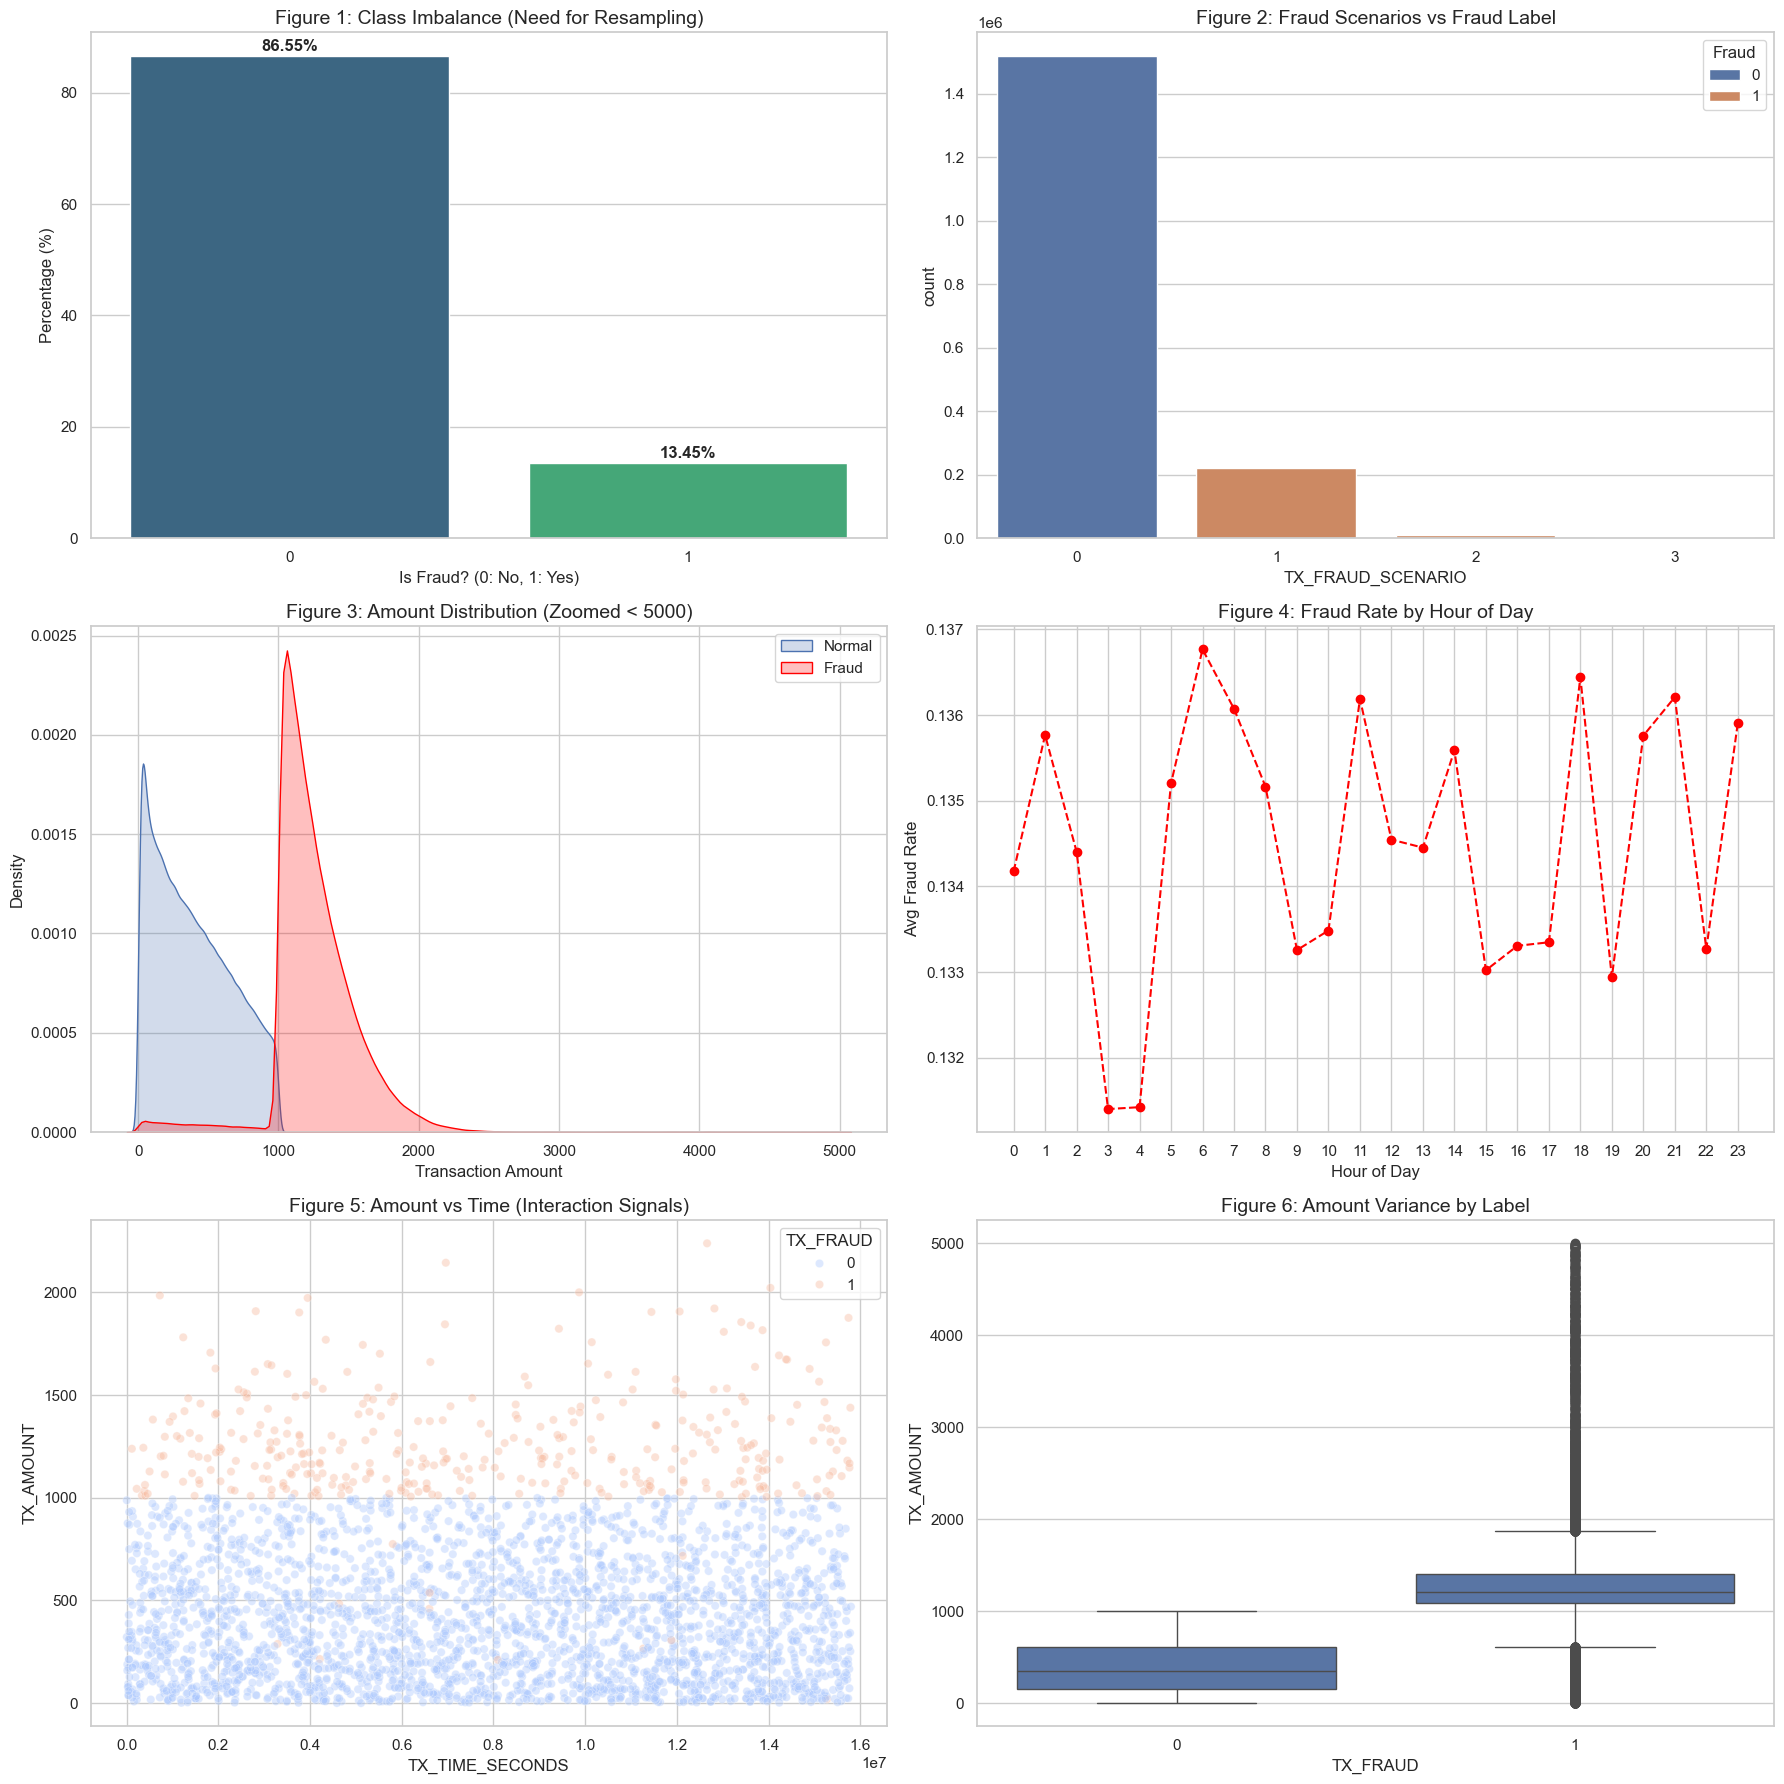

In [4]:
# 設定繪圖風格
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (18, 14)

def perform_eda_for_paper_support(df):
    print("=== 開始進行基於論文支持的 EDA 分析 ===")
    
    # 建立一個 3x2 的畫布
    fig, axes = plt.subplots(3, 2, figsize=(18, 18))
    plt.subplots_adjust(hspace=0.4)

    # A. 類別不平衡分析 (支持 SMOTE / ADASYN / Class Weight 實驗)
    fraud_counts = df['TX_FRAUD'].value_counts(normalize=True) * 100
    sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis', ax=axes[0, 0])
    axes[0, 0].set_title('Figure 1: Class Imbalance (Need for Resampling)', fontsize=14)
    axes[0, 0].set_ylabel('Percentage (%)')
    axes[0, 0].set_xlabel('Is Fraud? (0: No, 1: Yes)')
    for i, v in enumerate(fraud_counts.values):
        axes[0, 0].text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')

    # B. 詐騙情境分析 (支持多模型集成處理複雜特徵交互)
    sns.countplot(x='TX_FRAUD_SCENARIO', hue='TX_FRAUD', data=df, ax=axes[0, 1])
    axes[0, 1].set_title("Figure 2: Fraud Scenarios vs Fraud Label", fontsize=14)
    axes[0, 1].legend(title='Fraud', loc='upper right')

    # C. 交易金額分佈 - 拉近看 (支持 GBDT 處理非線性分佈與 Outlier 魯棒性)
    # 過濾掉極大離群值以便觀察主要分佈
    limit = 5000 
    normal_amt = df[(df['TX_FRAUD'] == 0) & (df['TX_AMOUNT'] <= limit)]['TX_AMOUNT']
    fraud_amt = df[(df['TX_FRAUD'] == 1) & (df['TX_AMOUNT'] <= limit)]['TX_AMOUNT']
    
    sns.kdeplot(normal_amt, label='Normal', fill=True, ax=axes[1, 0])
    sns.kdeplot(fraud_amt, label='Fraud', fill=True, ax=axes[1, 0], color='red')
    axes[1, 0].set_title(f'Figure 3: Amount Distribution (Zoomed < {limit})', fontsize=14)
    axes[1, 0].set_xlabel('Transaction Amount')
    axes[1, 0].legend()

    # D. 時間規律分析 (支持特徵工程: hour / time_since_last_tx)
    if 'hour' not in df.columns:
        df['hour'] = pd.to_datetime(df['TX_DATETIME']).dt.hour
    fraud_rate_by_hour = df.groupby('hour')['TX_FRAUD'].mean()
    axes[1, 1].plot(fraud_rate_by_hour.index, fraud_rate_by_hour.values, marker='o', color='red', linestyle='--')
    axes[1, 1].set_title('Figure 4: Fraud Rate by Hour of Day', fontsize=14)
    axes[1, 1].set_ylabel('Avg Fraud Rate')
    axes[1, 1].set_xlabel('Hour of Day')
    axes[1, 1].set_xticks(range(0, 24))

    # E. 金額與時間的交互關聯 (支持 Mahalanobis 離群值檢測實驗)
    # 同樣對金額進行過濾以便在散佈圖觀察規律
    sample_df = df[df['TX_AMOUNT'] <= limit].sample(min(3000, len(df)))
    sns.scatterplot(data=sample_df, x='TX_TIME_SECONDS', y='TX_AMOUNT', 
                    hue='TX_FRAUD', alpha=0.4, palette='coolwarm', ax=axes[2, 0])
    axes[2, 0].set_title('Figure 5: Amount vs Time (Interaction Signals)', fontsize=14)

    # F. 箱型圖觀察偏態 (支持 Robust Scaling 與 Ensemble 優勢)
    sns.boxplot(x='TX_FRAUD', y='TX_AMOUNT', data=df[df['TX_AMOUNT'] <= limit], ax=axes[2, 1])
    axes[2, 1].set_title('Figure 6: Amount Variance by Label', fontsize=14)

    plt.tight_layout()
    plt.show()


perform_eda_for_paper_support(data)

相關性

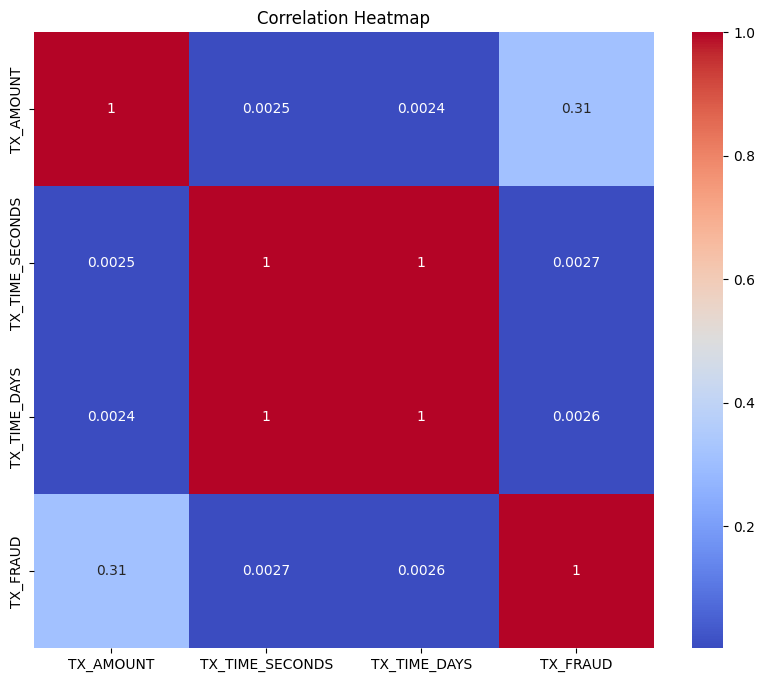

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(data[['TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_FRAUD']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

從 EDA 的結果中觀察到這份數據具備兩個挑戰：
第一，圖 1 顯示的『不平衡』，詐騙案件不到 20%；第二，圖 3、4、6 以及相關性熱力圖揭示了交易的『行為隱蔽性』，詐騙與正常交易在金額分布上存在重疊，並且在夜晚等特定時段才顯露異常，這使得模型辨識難度提高。
針對這些數據特點，我參考了 Chen et al. (2026) 的最新綜述研究，該論文指出集成學習（Ensemble）在 F1 分數上平均可達 92.66%，是目前防詐偵測的重要標竿，因此我決定設計兩套實驗來尋找最佳解。

首先，使用『純集成方法 (Pure Ensemble)』，利用 XGB、LGB 與 CatBoost 多種算法來捕捉非線性規律，並採用所謂的『代價敏感學習 (Cost-sensitive Learning)』——簡單來說，這就是調高模型對於漏抓詐騙的『處罰力度』，讓模型較為敏感，即便在大量正常交易的干擾下，也能對細微的異常維持高靈敏度。
然而，考量到圖 1 顯示的樣本稀缺性可能讓模型陷入『有能力卻缺乏資料支撐』的困境，因此我進一步挑戰了『Ensemble + Hybrid 複合優化路徑』。，因此我進一步挑戰了『Ensemble + Hybrid 複合優化路徑』。這部分我遵循了 Chawla et al. (2002) 的經典理論，透過 SMOTE 採樣技術人工合成詐騙樣本，強行在數據稀疏的空間中『補強訊號』；同時，針對圖 5 觀察到的多維交互異常，我加入了Mahalanobis 距離等進階特徵來量化偏離感，最後使用『疊加模型 (Stacking)』架構，像是運用集合不同專長的專家進行討論，並最終由（Meta-learner）根據專家的投票做最後判斷。

總之，我之選擇這兩個實驗，是為了模擬在真實金融場景中，單純調整『模型警覺性』與全面進行『數據與特徵重組』哪一個方案更具備穩健性與效率，不僅追求 F1 分數的提升，更具備根據數據現狀與學術架構來精準解決實務痛點。